
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Astronomical Tide (AT), Monthly Mean Sea Level (MMSL) & Surge due to Sea Level Pressure (IB) to compute Total Water Level (TWL)

inputs required:
* Sea Level from tide gauge (TG)
* Sea Level pressure from CFSR

in this notebook:
* Obtain AT from TG using Utide library (http://www.po.gso.uri.edu/~codiga/utide/utide.htm)
* Obtain MMSL from TG
* Transform SLP variations into sea level variations (Inverse Barometer)
* Compute TWL as: AT + MMSL + IB

  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress
from datetime import datetime

import utide # https://github.com/wesleybowman/UTide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL


from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 96, time: 359401)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * longitude  (longitude) float32 100.0 102.0 104.0 106.0 ... 286.0 288.0 290.0
  * latitude   (latitude) float32 80.0 78.0 76.0 74.0 ... -74.0 -76.0 -78.0
Data variables:
    SLP        (time, latitude, longitude) float64 ...

b'Kwajalein'

<xarray.Dataset>
Dimensions:               (time: 636131)
Coordinates:
  * time                  (time) datetime64[ns] 1946-06-07T13:00:00 ... 2018-12-31T23:00:00
Data variables:
    sea_level             (time) float32 0.1511321 0.060132146 ... 0.1281321
    lat                   float32 ...
    lon                   float32 ...
    station_name          |S9 b'Kwajalein'
    station_country       |S22 ...
    station_country_code  float32 ...
    uhslc_id              int16 ...
    version               |S1 ...
    gloss_id              float32 ...
    ssc_id                |S4 ...
    decimation_

Text(0.5, 1.0, 'sea level from UHSLC Tide Gauge')

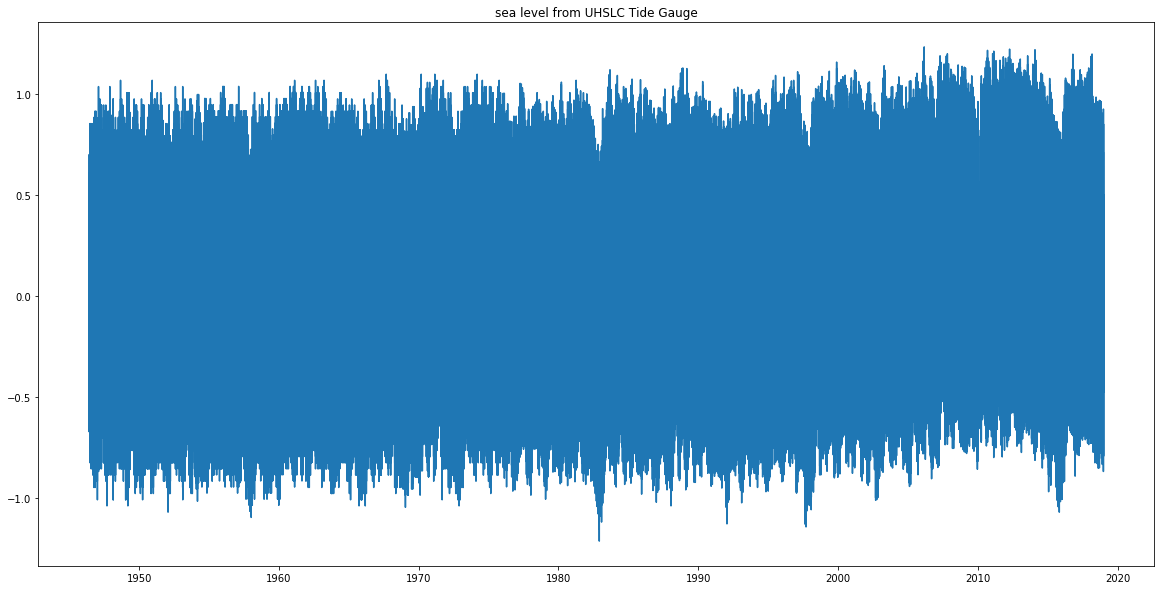

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_hindcast')


# --------------------------------------
# Sea Level Pressure for obtain level due to Inverse Barometer (IB)
SLP = db.Load_ESTELA_SLP()   # Sea Level Pressure from CFSR (Pa)
print(SLP)
print()

# Kwajalein: pnt_lon = 167.73, pnt_lat = 8.66
lonp = 168 # closest coordinates in SLP dataset
latp = 8


# --------------------------------------
# parameters for mmsl calculation
mmsl_year_ini = 1950
mmsl_year_end = 2018


# --------------------------------------
# Load TG from UHSLC (research quality)
TG, _ = db.Load_TIDE_hist()  
TG = TG.squeeze(dim='record_id')
TG = TG.reset_coords(names='record_id', drop=True)
print(TG.station_name.values)
print()

# to meters and mean sea level = 0
TG['sea_level'] = TG['sea_level']/1000
TG['sea_level'] = TG['sea_level'] - np.nanmean(TG['sea_level'].values)

# round time to exact hour
TG['time'] = TG['time'].dt.round('H')
print(TG)

plt.figure(figsize=(20,10))
plt.plot(TG.time, TG.sea_level)
plt.title('sea level from UHSLC Tide Gauge')


## Obtain Historical level time series:

#### Obtain astronomical tide (AT)

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
<xarray.Dataset>
Dimensions:    (time: 636131)
Coordinates:
  * time       (time) datetime64[ns] 1946-06-07T13:00:00 ... 2018-12-31T23:00:00
Data variables:
    sea_level  (time) float32 0.1511321 0.060132146 ... -0.03886795 0.1281321
    AT         (time) float64 0.1782 0.09148 -0.01022 ... -0.2364 -0.05051 0.143


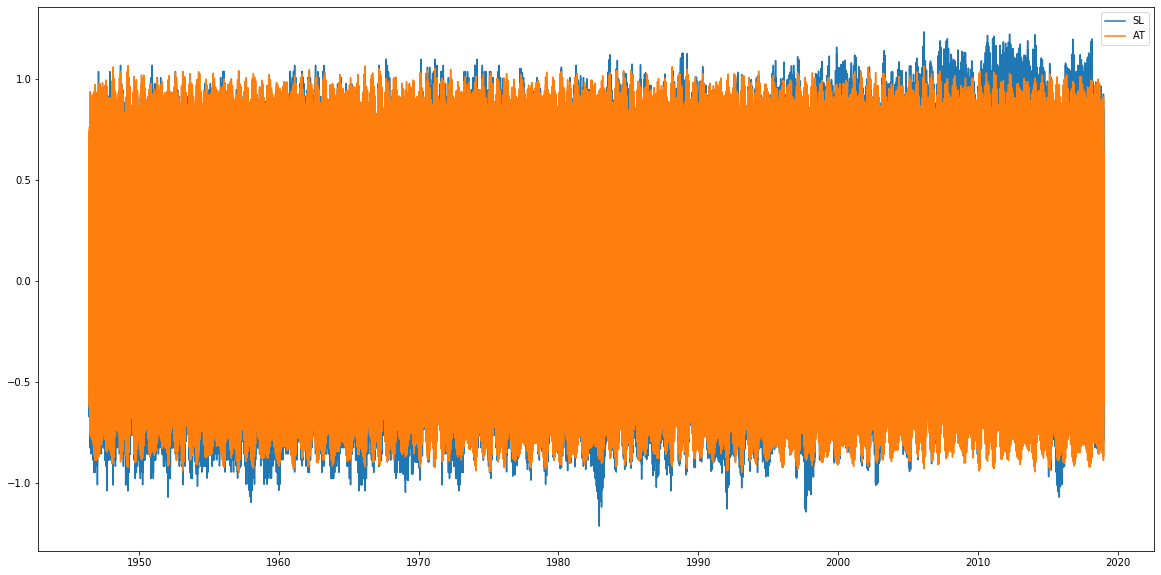

In [3]:
# --------------------------------------
# Obtain AT from TG sea level

# Utide library
#    Parameters
#    ----------
#    t : array_like
#        Time in days since `epoch`.
#    u : array_like
#        Sea-surface height, velocity component, etc.
#    v : {None, array_like}, optional
#        If `u` is a velocity component, `v` is the orthogonal component.
#    lat : float, required
#        Latitude in degrees.
#    epoch : {string, `datetime.date`, `datetime.datetime`}, optional
#        Valid strings are 'python' (default); 'matlab' if `t` is
#        an array of Matlab datenums; or an arbitrary date in the
#        form 'YYYY-MM-DD'.  The default corresponds to the Python
#        standard library `datetime` proleptic Gregorian calendar,
#        starting with 1 at 00:00 on January 1 of year 1; this is
#        the 'datenum' used by Matplotlib.
#    constit : {'auto', array_like}, optional
#        List of strings with standard letter abbreviations of
#        tidal constituents; or 'auto' to let the list be determined
#        based on the time span.
#    conf_int : {'linear', 'MC', 'none'}, optional
#        If not 'none' (string), calculate linearized confidence
#        intervals, or use a Monte-Carlo simulation.
#    method : {'ols', 'robust'}, optional
#        Solve with ordinary least squares, or with a robust algorithm.
#    trend : bool, optional
#        True (default) to include a linear trend in the model.
#    phase : {'Greenwich', 'linear_time', 'raw'}, optional
#        Give Greenwich-referenced phase lags, an approximation
#        using linearized times, or raw lags.
#    nodal : {True, False, 'linear_time'}, optional
#        True (default) to include nodal/satellite corrections;
#        'linear_time' to use the linearized time approximation;
#        False to omit nodal corrections.
        
        
coef = utide.solve(
    matplotlib.dates.date2num(TG.time.values), TG.sea_level.values,
    lat=TG.lat.values,
    nodal=True,
    trend=False,
    method='ols',
    conf_int='MC',
)

tide_tt = utide.reconstruct(matplotlib.dates.date2num(TG.time.values), coef).h


# Plot 
plt.figure(figsize=(20,10))
plt.plot(TG.time, TG.sea_level, label = 'SL')
plt.plot(TG.time, tide_tt, label = 'AT')
plt.legend()


# save
TG_AT = TG.sea_level.copy(deep=True)
TG_AT = TG_AT.to_dataset()
TG_AT['AT']= (('time'),tide_tt)
TG_AT = TG_AT.reset_coords(names='AT')

TG_AT.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast','TIDE','TG_Kwajalein.nc'))
print(TG_AT)


#### Obtain Monthly Mean Sea Level (MMSL)

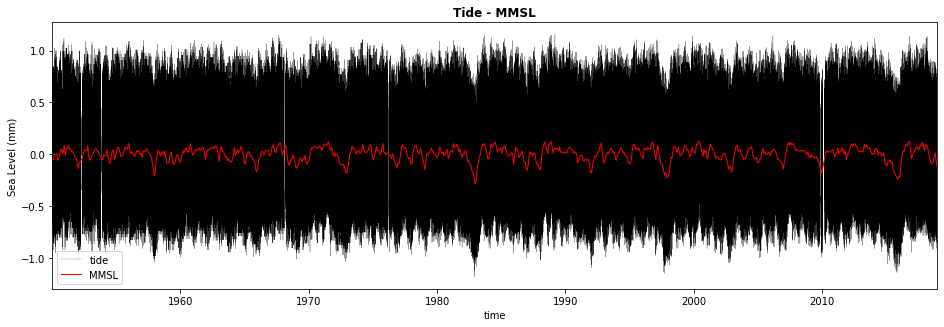

<xarray.Dataset>
Dimensions:      (time: 820)
Coordinates:
  * time         (time) datetime64[ns] 1950-01-16T11:00:00 ... 2018-12-16T11:00:00
Data variables:
    mmsl         (time) float64 -0.04985 -0.0534 0.001096 ... -0.06441 -0.1258
    mmsl_median  (time) float64 -0.07112 -0.07082 -0.009761 ... -0.07653 -0.1225
Attributes:
    source:   teslakit_v0.9.1


In [4]:
# --------------------------------------
# Obtain Monthly Mean Sea Level (MMSL) from TG sea level

SL = TG.sea_level.copy(deep=True)


# ---------------
# obtain SLR
lr_time = np.array(range(len(SL.time)))  # for linregress
ind_nan = np.where(~np.isnan(SL.values)) # ind no NaNs
slope, intercept, r_value, p_value, std_err = linregress(lr_time[ind_nan], SL.values[ind_nan])
slr = intercept + slope * lr_time

# remove SLR 
SL_noslr = SL - slr


# ---------------
# calculate running mean
time_window = 365*24*3
runm = runmean(SL_noslr, time_window, 'mean')

# remove running mean
SL_noslr_norunm = SL_noslr - runm
SLNSR = xr.DataArray(SL_noslr_norunm,  dims=('time'), coords={'time':SL.time.values})


# ---------------
# calculate MMSL
MMSL = Calculate_MMSL(SLNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]


# Plot tide and mmsl 
Plot_Tide_MMSL(SLNSR.time, SLNSR.values, mmsl_time, mmsl_vals);


# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)
print(MMSL)



#### Obtain sea level variation due to SLP differences

In [14]:
# --------------------------------------
# Inverse Barometer (IB)

# select closest grid point to Site
SLP_p = SLP.sel(longitude = lonp, latitude = latp) 

# Calculate anomalies and change units 
SLP_p['SLP'] = SLP_p.SLP*0.01 # (Pa to mb)
SLP_p['SLP_anomaly'] = SLP_p.SLP - np.mean(SLP_p.SLP.values)

SLP_p['level_IB'] = -1*SLP_p.SLP_anomaly # (Inverse Barometer: mb to cm)
SLP_p['level_IB'] = SLP_p.level_IB/100.0 # (cm to m)
print(SLP_p)

# store
SLP_p.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast','TIDE','slp_surge.nc'))

<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude    float32 168.0
    latitude     float32 8.0
Data variables:
    SLP          (time) float64 1.007e+03 1.007e+03 ... 1.013e+03 1.012e+03
    SLP_anomaly  (time) float64 -3.029 -3.042 -3.243 -3.66 ... 3.156 3.07 2.555
    level_IB     (time) float64 0.03029 0.03042 0.03243 ... -0.0307 -0.02555


## Compute TWL

In [17]:
# --------------------------------------
# Compute Total Water Level (TWL)


# from monthly to hourly
MMSL = MMSL.mmsl.resample(time='1H').interpolate("linear")


# hourly values
TG_AT['time'] = TG_AT['time'].dt.round('H')
MMSL['time'] = MMSL['time'].dt.round('H')
SLP_p['time'] = SLP_p['time'].dt.round('H')

# remove duplicates
_, ix = np.unique(TG_AT['time'], return_index=True); TG_AT = TG_AT.isel(time=ix)
_, ix = np.unique(MMSL['time'], return_index=True); MMSL = MMSL.isel(time=ix)
_, ix = np.unique(IB['time'], return_index=True); IB = IB.isel(time=ix)


# get TWL
TWL = TG_AT.AT + MMSL + SLP_p.level_IB
print(TG_AT.AT)
print(MMSL)
print(SLP_p.level_IB)


# save
TWL = TWL.to_dataset(name='TWL')
TWL.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast','TIDE','hist_TWL.nc'))
print(TWL)



<xarray.DataArray 'AT' (time: 636131)>
array([ 0.17818217,  0.09148153, -0.01022043, ..., -0.23643434,
       -0.0505144 ,  0.1430177 ])
Coordinates:
  * time     (time) datetime64[ns] 1946-06-07T13:00:00 ... 2018-12-31T23:00:00
<xarray.DataArray 'mmsl' (time: 604105)>
array([-0.04985126, -0.04985627, -0.04986128, ..., -0.12567807,
       -0.125762  , -0.12584592])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T11:00:00 ... 2018-12-16T11:00:00
Attributes:
    units:       meters
    short_name:  mmsl
    long_name:   monthly mean sea level
<xarray.DataArray 'level_IB' (time: 359401)>
array([ 0.0302886 ,  0.03041907,  0.03242845, ..., -0.03155749,
       -0.03070359, -0.02555202])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude  float32 168.0
    latitude   float32 8.0
<xarray.Dataset>
Dimensions:    (time: 350268)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
    longitude  float32 168.0
    la

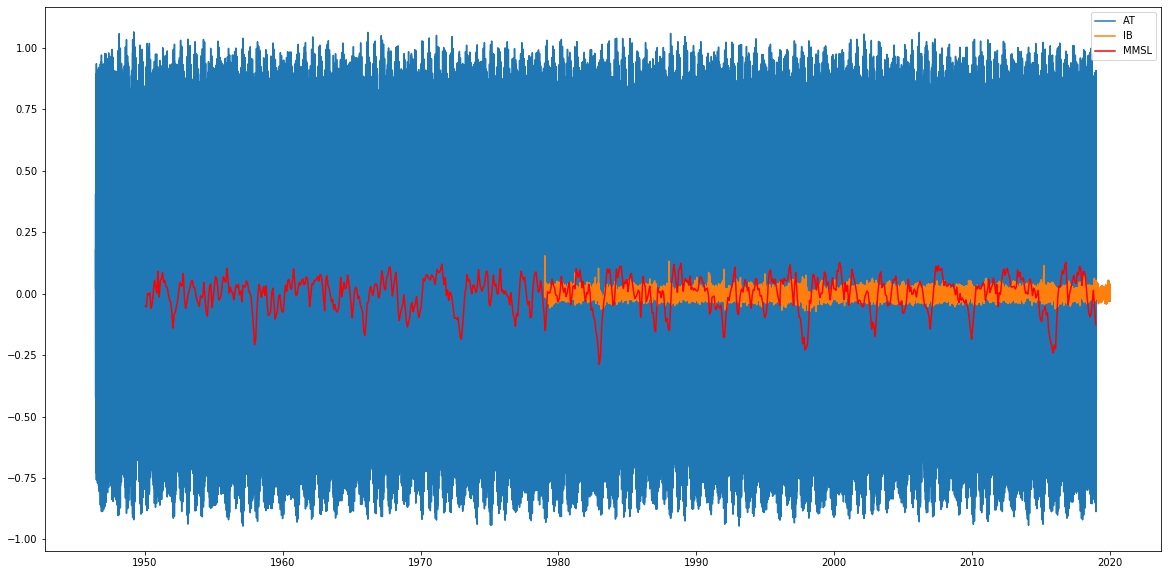

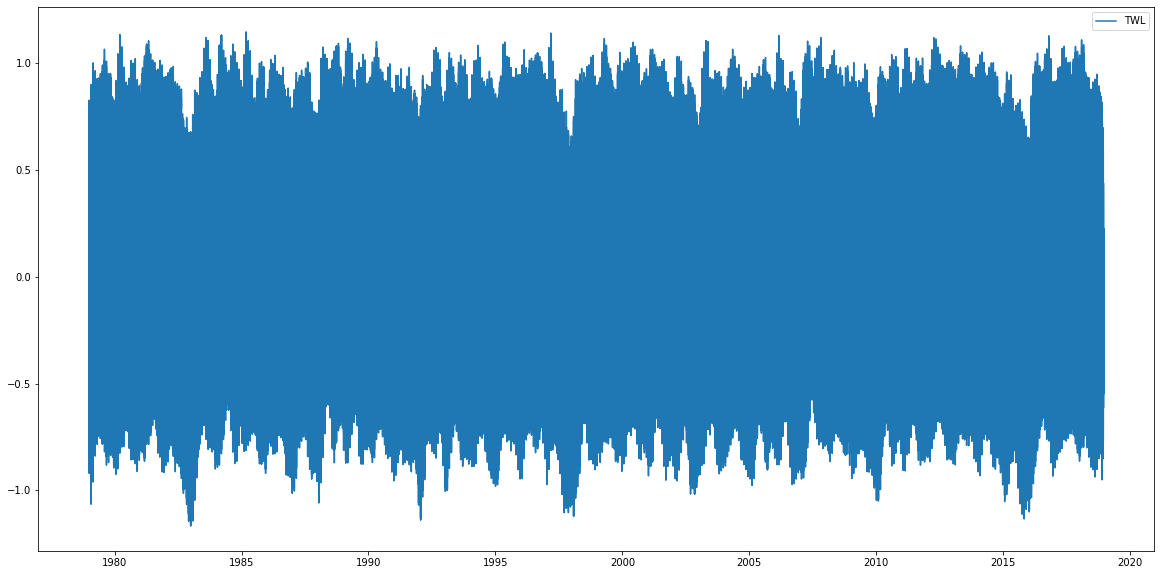

In [18]:

# plot
plt.figure(figsize=(20,10))
plt.plot(TG_AT.time, TG_AT.AT, label='AT')
plt.plot(SLP_p.time, SLP_p.level_IB, label='IB')
plt.plot(MMSL.time, MMSL, color = 'r', label='MMSL')
plt.legend()
#plt.xlim(datetime(1996,1,1), datetime(2014,1,1))

plt.figure(figsize=(20,10))
plt.plot(TWL.time, TWL.TWL, label = 'TWL')
plt.legend()
#plt.xlim(datetime(1996,1,1), datetime(2014,1,1))